In [ ]:
import pandas as pd
import gdown
import os
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
from sklearn.model_selection import train_test_split, GridSearchCV

output_dir = "../data/california/"
output_path = f"{output_dir}california_accidents.csv"
cleanded_output_path = f"{output_dir}cleaned_california_accidents.csv"

california_file_id = "1X942vMl8jntbRs7heqYa22HFb8-q6M3T"

def load_data(file_id):
    if not os.path.exists(output_path):
        gdown.download(f"https://drive.google.com/uc?id={file_id}", output_path, quiet=False)

    return pd.read_csv(output_path, sep=",", low_memory=False)  # Prevent dtype warnings

def clean_data(california_data):
    #missing percentage
    missing_percentage = california_data.isnull().mean() * 100
    
    # drop columns with more than 5%  missing values
    california_data_clean = california_data.copy()
    cols_to_keep = [col for col in california_data.columns if missing_percentage[col] <= 5]
    california_data_clean = california_data[cols_to_keep]
    
    # Checking the remaing missing values
    california_data_clean.isnull().mean().sort_values(ascending=False).head(15)
    
    # Drop unrelated columns
    cols_to_drop = ['Nautical_Twilight', 'Astronomical_Twilight','Civil_Twilight','Airport_Code','Sunrise_Sunset', 'ID', 'Source', 'Description']
    california_data_clean = california_data_clean.drop(cols_to_drop, axis=1)

    # Drop rows in columns with <1% missing values
    cols_to_check = ['Start_Time', 'End_Time', 'Wind_Direction', 'Humidity(%)', 'Weather_Condition', 'Visibility(mi)', 'Temperature(F)', 'Pressure(in)', 'Weather_Timestamp',
                    'Street', 'Timezone']
    df_california = california_data_clean.dropna(subset=cols_to_check)
    
    #check for duplicates
    if (df_california.duplicated().sum() > 0):
        print('WARNING: Number of duplicates: ',df_california.duplicated().sum())

    # Chekcing the data types of the columns
    print(df_california['Start_Time'].dtype)
    print(df_california['End_Time'].dtype)

    # Convert Start_Time and End_Time to datetime
    df_california.loc[:, 'Start_Time'] = pd.to_datetime(df_california['Start_Time'],errors='coerce')
    df_california.loc[:, 'End_Time'] = pd.to_datetime(df_california['End_Time'],errors='coerce')

    # Drop rows where conversion failed
    df_california = df_california[df_california['Start_Time'].notna() & df_california['End_Time'].notna()]

    # Save cleaned dataset
    df_california.to_csv(cleanded_output_path, index=False)

    df_california = pd.read_csv(cleanded_output_path, parse_dates=['Start_Time', 'End_Time'])
    
    return df_california



california_data = load_data(california_file_id)
california_clened_data = clean_data(california_data)

<bound method DataFrame.info of                 ID   Source  Severity           Start_Time  \
194250    A-194257  Source2         3  2016-11-30 16:25:41   
194251    A-194258  Source2         3  2016-11-30 15:40:06   
194252    A-194259  Source2         3  2016-11-30 15:26:18   
194253    A-194260  Source2         3  2016-11-30 16:14:11   
194254    A-194261  Source2         3  2016-11-30 16:17:57   
...            ...      ...       ...                  ...   
7728007  A-7777375  Source1         2  2019-08-23 16:48:32   
7728011  A-7777379  Source1         2  2019-08-23 16:16:21   
7728012  A-7777380  Source1         2  2019-08-23 16:40:16   
7728019  A-7777387  Source1         2  2019-08-23 19:20:28   
7728020  A-7777388  Source1         2  2019-08-23 17:51:33   

                    End_Time  Start_Lat  Start_Lng    End_Lat    End_Lng  \
194250   2016-11-30 17:10:30  41.139324 -74.169876        NaN        NaN   
194251   2016-11-30 17:09:40  41.118748 -74.159744        NaN        Na

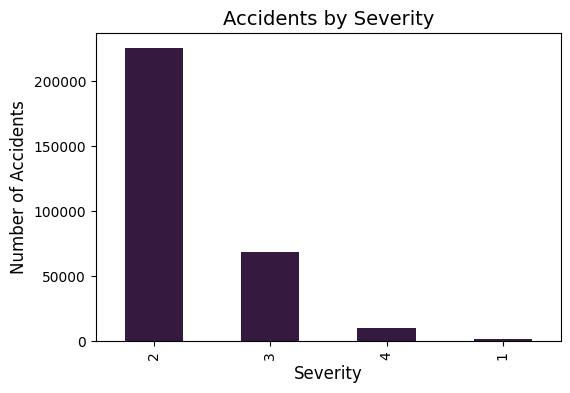

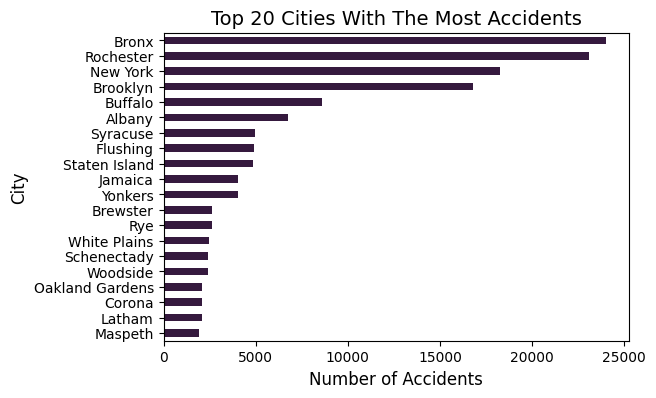

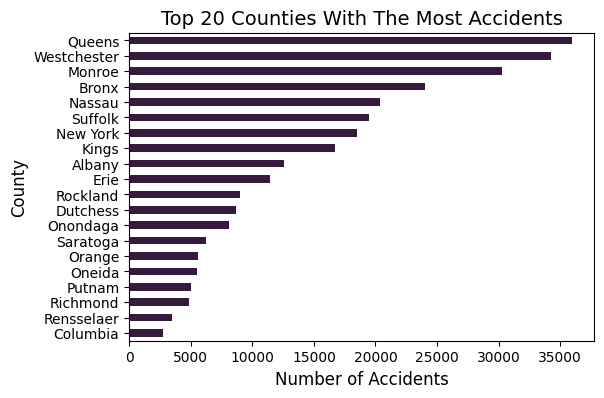

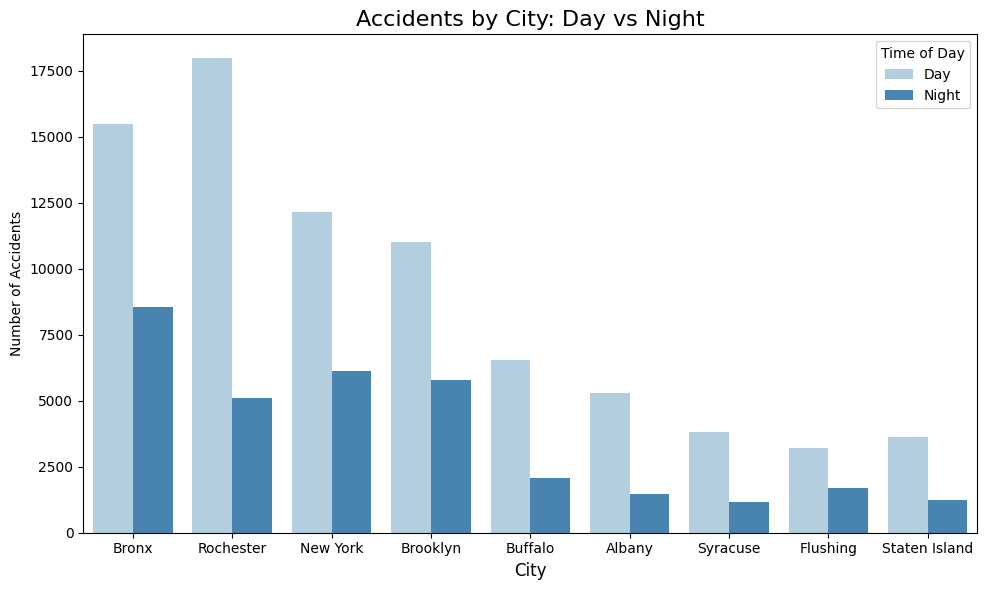

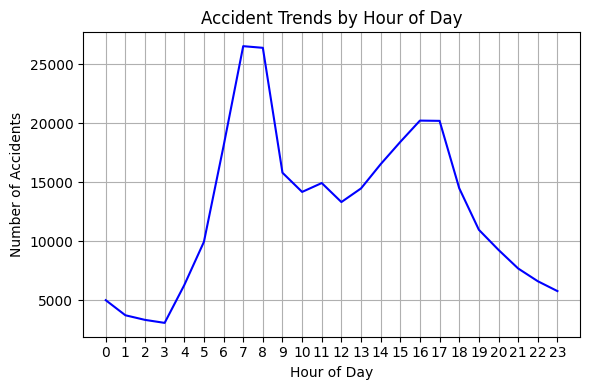

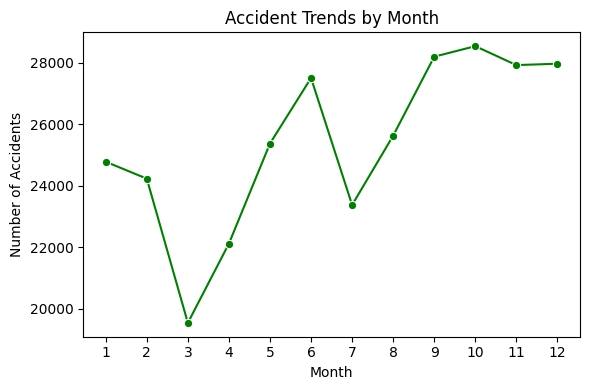

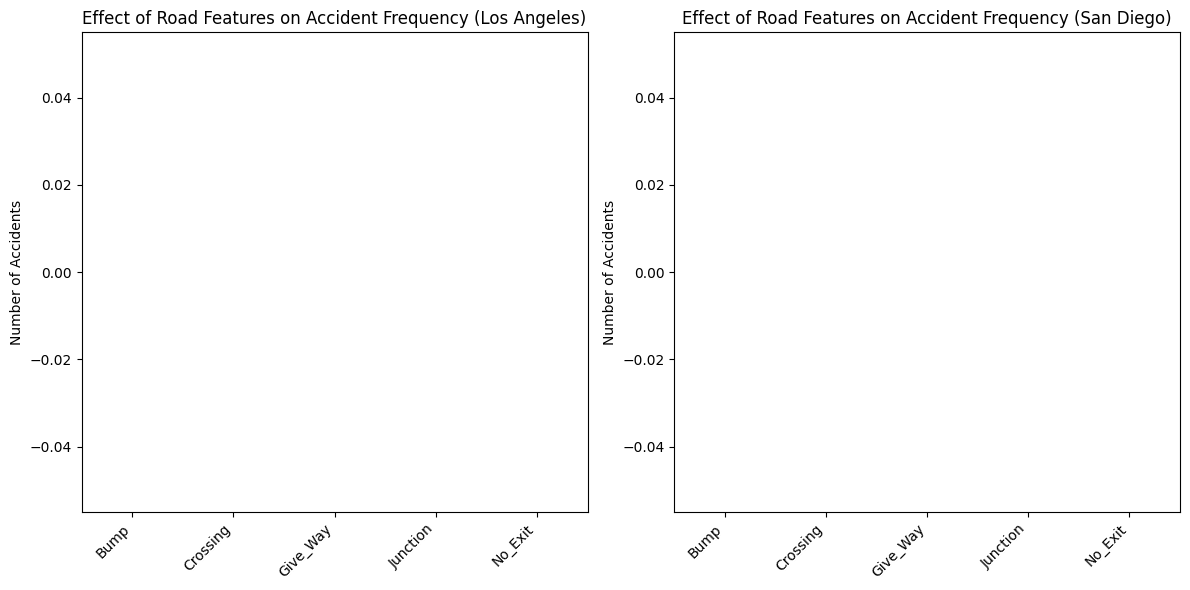

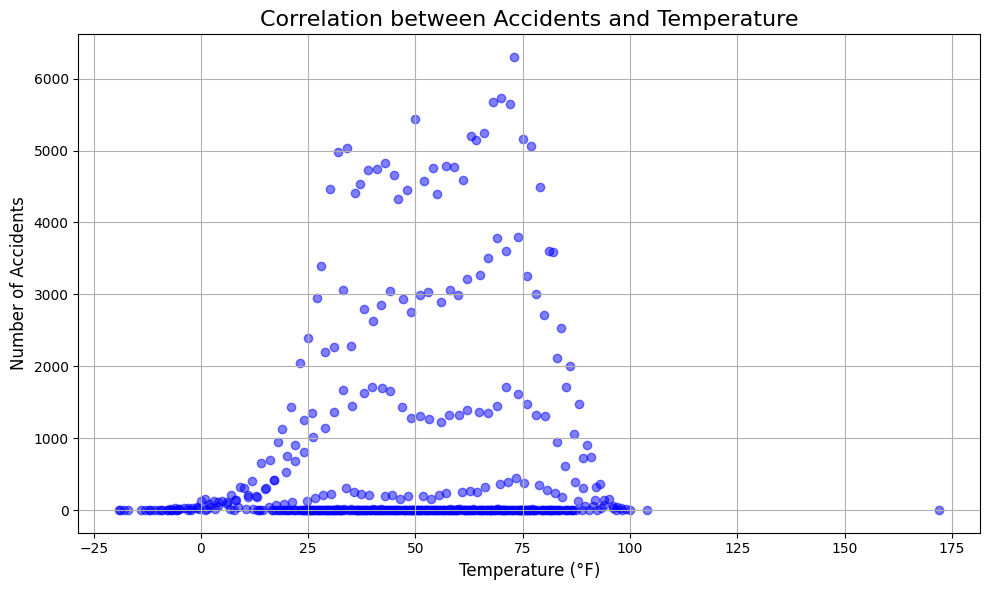

Correlation between accidents and temperature: 0.15882091846275032


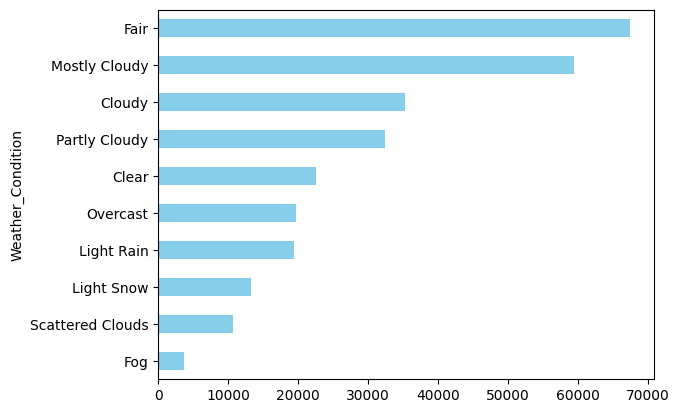

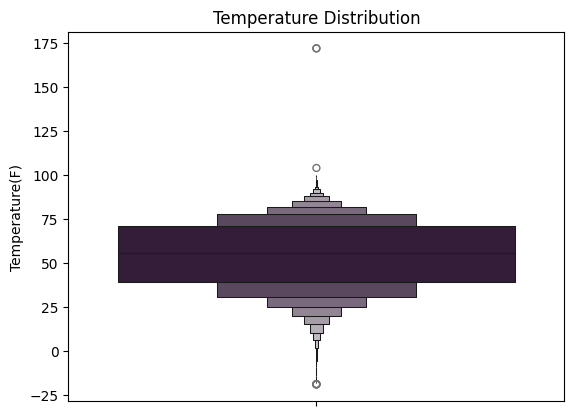

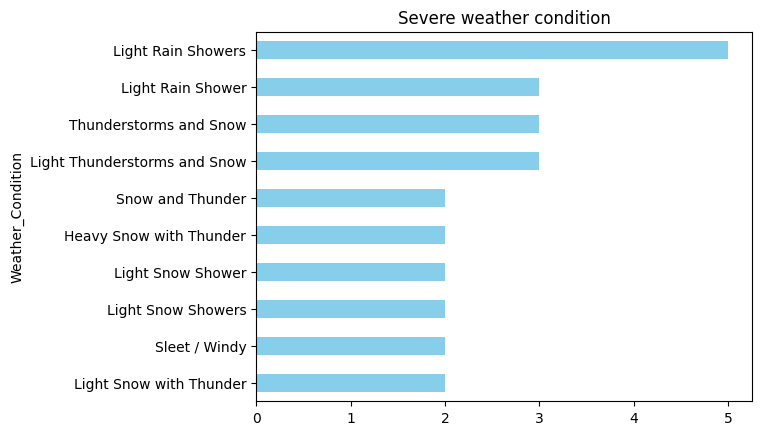

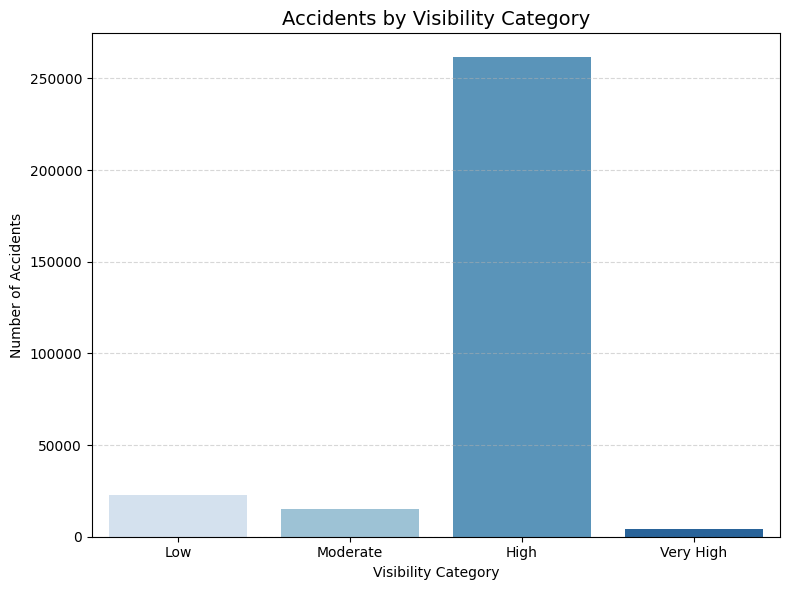

In [26]:
def plot_accidents_by_severity(california_data):
    plt.figure(figsize=(6,4))
    california_data['Severity'].value_counts().plot(kind='bar')
    plt.title('Accidents by Severity', fontsize=14)
    plt.xlabel('Severity', fontsize=12)
    plt.ylabel('Number of Accidents', fontsize=12)
    plt.show()

def plot_accidents_by_city(california_data):
    plt.figure(figsize=(6,4))
    top_cities = california_data['City'].value_counts().head(20).sort_values()
    top_cities.plot(kind='barh')
    plt.title('Top 20 Cities With The Most Accidents', fontsize=14)
    plt.xlabel('Number of Accidents', fontsize=12)
    plt.ylabel('City', fontsize=12)
    plt.show()

def plot_accidents_by_county(california_data):
    """#+
    This function plots a bar chart showing the top 20 counties with the most accidents.#+
#+
    Parameters:#+
    california_data (DataFrame): A pandas DataFrame containing the California accident data.#+
#+
    Returns:#+
    None. The function displays a bar chart.#+
    """#+
    plt.figure(figsize=(6,4))
    top_counties = california_data['County'].value_counts().head(20).sort_values()
    top_counties.plot(kind='barh')
    plt.title('Top 20 Counties With The Most Accidents', fontsize=14)
    plt.xlabel('Number of Accidents', fontsize=12)
    plt.ylabel('County', fontsize=12)
    plt.show()

def plot_accidents_by_category(df, category_column, top_n=10):
    
    df.loc[:, 'Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
    
    # Drop rows with missing Start_Time
    df = df.dropna(subset=['Start_Time'])
    
    # Extract the hour from the Start_Time column
    df.loc[:, 'hour'] = df['Start_Time'].dt.hour
        
    # Classify accidents into day or night
    def day_night(hour):
        if 6 <= hour < 18:
            return 'Day'
        else:
            return 'Night'
            
    
    # Apply function to the hour column
    df.loc[:, 'Day_Night'] = df['hour'].apply(day_night)

    # Get the top N categories with the most accidents
    top_categories = df[category_column].value_counts().head(top_n).index

    # Filter data for top N categories
    df_top_categories = df[df[category_column].isin(top_categories)]

    # Get the order of categories based on their counts
    order = df_top_categories[category_column].value_counts().index[:-1]

    # Create the countplot for accidents by category and day/night
    plt.figure(figsize=(10, 6))
    sns.set_palette("rocket")
    sns.countplot(data=df_top_categories, x=category_column, hue='Day_Night', order=order, palette='Blues')

    plt.title(f'Accidents by {category_column.capitalize()}: Day vs Night', fontsize=16)
    plt.xlabel(f'{category_column.capitalize()}', fontsize=12)
    plt.ylabel('Number of Accidents', fontsize=10)
    plt.legend(title='Time of Day', loc='upper right', fontsize=10)
    plt.tight_layout()

    plt.show()

def plot_accidents_by_hour_of_day(california_data):
    # Extract the month from the Start_Time column
    california_data.loc[:, 'Month'] = california_data['Start_Time'].dt.month
    california_data.loc[:, 'hour'] = california_data['Start_Time'].dt.hour

    #Accidentd by hour
    plt.figure(figsize=(6,4))
    hour_accidents = california_data['hour'].value_counts().sort_index()
    sns.lineplot(x=hour_accidents.index, y=hour_accidents.values, markers='o', color='b')
    plt.title('Accident Trends by Hour of Day')
    plt.xlabel('Hour of Day')
    plt.ylabel('Number of Accidents')
    plt.xticks(range(24))  # Show all 24 hours
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_accidents_by_month(california_data):
    plt.figure(figsize=(6,4))
    monthly_accidents = california_data['Month'].value_counts().sort_index()  # Count accidents by month
    sns.lineplot(x=monthly_accidents.index, y=monthly_accidents.values, marker='o', color='g')
    plt.title('Accident Trends by Month')
    plt.xlabel('Month')
    plt.ylabel('Number of Accidents')
    plt.xticks(range(1, 13)) 
    plt.tight_layout()
    plt.show()


def plot_comparing_two_cities(california_data, city1, city2):
    # Selecting columns with the road features
    road_features = ['Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal']

    cityone = california_data[california_data['City'] == city1]

    # Sum the occurrences of each road feature for Houston
    cityone_feature_impact = cityone[road_features].sum().sort_values(ascending=False).head(5)

    # Filter data for accidents in Dallas
    citytwo_data = california_data[california_data['City'] == city2]

    # Sum the occurrences of each road feature for Dallas
    citytwo_feature_impact = citytwo_data[road_features].sum().sort_values(ascending=False).head(5)

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot Houston feature impact
    cityone_feature_impact.plot(kind='bar', ax=axes[0], color='skyblue')
    axes[0].set_title('Effect of Road Features on Accident Frequency (Los Angeles)')
    axes[0].set_ylabel('Number of Accidents')
    axes[0].set_xticklabels(cityone_feature_impact.index, rotation=45, ha='right')

    # Plot Dallas feature impact
    citytwo_feature_impact.plot(kind='bar', ax=axes[1], color='lightgreen')
    axes[1].set_title('Effect of Road Features on Accident Frequency (San Diego)')
    axes[1].set_ylabel('Number of Accidents')
    axes[1].set_xticklabels(citytwo_feature_impact.index, rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

def plot_correlation_of_temperature(california_data):
    # Group by temperature and count the accidents
    temperature_accidents = california_data.groupby('Temperature(F)').size()
    # Plot the correlation between accidents and temperature
    plt.figure(figsize=(10, 6))
    plt.scatter(temperature_accidents.index, temperature_accidents.values, color='blue', alpha=0.5)
    plt.title('Correlation between Accidents and Temperature', fontsize=16)
    plt.xlabel('Temperature (°F)', fontsize=12)
    plt.ylabel('Number of Accidents', fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    # Optionally, calculate the correlation coefficient between accidents and temperature
    correlation = california_data['Temperature(F)'].corr(california_data.groupby('Temperature(F)').size())
    print(f'Correlation between accidents and temperature: {correlation}')

def plot_weather_condition(california_data):
    # Weather conditions
    weather_cond = california_data['Weather_Condition'].value_counts().head(10).sort_values()
    weather_cond.plot(kind='barh', color='skyblue')
    plt.show()

def plot_temperature_distribution(california_data):
    sns.boxenplot(california_data['Temperature(F)'])
    plt.title('Temperature Distribution')
    plt.show()

def plot_sever_weather_condition(california_data):
    plt.title('Severe weather condition')

    severity_weather = california_data.groupby('Weather_Condition')['Severity'].sum().sort_values(ascending=True).head(10)
    # print(severity_weather)
    severity_weather.plot(kind='barh', color='skyblue')
    plt.show()


def plot_accidents_by_visibility(california_data):
    # Sort values into bins
    california_data['Visibility_Category'] = pd.cut(
        california_data['Visibility(mi)'], 
        bins=[0, 2, 5, 10, 15], 
        labels=['Low', 'Moderate', 'High', 'Very High']
    )

    visibility_category_accidents = california_data['Visibility_Category'].value_counts().sort_index()

    plt.figure(figsize=(8, 6))
    sns.barplot(
        x=visibility_category_accidents.index, 
        y=visibility_category_accidents.values, 
        palette='Blues', hue=visibility_category_accidents.index
    )
    plt.title('Accidents by Visibility Category', fontsize=14)
    plt.xlabel('Visibility Category', fontsize=10)
    plt.ylabel('Number of Accidents', fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

def plot_location_heatmap(california_data):
    # Count accidents by coordinates
    california_data[['Start_Lat','Start_Lng']].isnull().sum()
    accidents_counts = california_data.groupby(['Start_Lat','Start_Lng']).size().reset_index(name='Num_of_accidents')
    heatmap_data = accidents_counts[['Start_Lat','Start_Lng','Num_of_accidents']].values.tolist()
    map_object = folium.Map(location=[accidents_counts['Start_Lat'].mean(), accidents_counts['Start_Lng'].mean()], zoom_start=6,tiles="Cartodb Positron", max_zoom=6, min_zoom=6)
    HeatMap(data=heatmap_data, radius=10, blur=10).add_to(map_object)
    map_object.save('../data/california/california_acc_heatmap.html') # Save the map to an HTML file
    return map_object

def get_popluation_data():
    # URL of the Wikipedia page
    url = 'https://en.wikipedia.org/wiki/List_of_largest_cities_in_California_by_population'

    # Read the tables on the page
    tables = pd.read_html(url)

    # The first table contains the city population data
    city_population_table = tables[0]

    # Save the table to a CSV file
    city_population_table.to_csv('california_city_populations.csv', index=False)

    print('Data has been saved to california_city_populations.csv')

    population_data = pd.read_csv('california_city_populations.csv', sep=",")
    population_data.columns

    # city_population_table = population_data['City', 'population_data']
    # city_population_table

# Accidents by severity
plot_accidents_by_severity(california_clened_data)

#Accidents by city
plot_accidents_by_city(california_clened_data)

# Accidents by county
plot_accidents_by_county(california_clened_data)

# Plotting accidents by county: day vs night
plot_accidents_by_category(california_clened_data, 'City', top_n=10)

# Plotting accidents by hour of the day
plot_accidents_by_hour_of_day(california_clened_data)

# Plotting accidents by month
plot_accidents_by_month(california_clened_data)

# Plotting by comparing two cities based on the reason for the accident
plot_comparing_two_cities(california_clened_data, 'Los Angeles', 'San Diego')

# Plotting correlations between temperature and accidents
plot_correlation_of_temperature(california_clened_data)

# Plot weather conditions
plot_weather_condition(california_clened_data)

# Plotting temperature distribution
plot_temperature_distribution(california_clened_data)

# #plotting severe weather conditions
plot_sever_weather_condition(california_clened_data)

# Plotting by visibility
plot_accidents_by_visibility(california_clened_data)

# Plotting location heatmap of accidents
plot_location_heatmap(california_clened_data)
